This notebook will explore the use of the energy yield assessment (EYA) gap analysis method in OpenOA. This method attributes differences in an EYA-estimated and an operational assessment (OA) estimate of annual energy production (AEP; or net energy, P50). Differences in availability loss estimates, electrical loss estimates, and turbine ideal energy estimates are analyzed. The latter metric incorporates many aspects of an EYA, including the wind resource estimate, wake loss estimate, turbine performane, and blade degradation. 

In [1]:
from project_ENGIE import Project_Engie
from operational_analysis.methods import plant_analysis
from operational_analysis.methods import turbine_long_term_gross_energy
from operational_analysis.methods import electrical_losses
from operational_analysis.methods import eya_gap_analysis

In [2]:
# Load plant object
project = Project_Engie('./data/la_haute_borne/')
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


In [3]:
pa = plant_analysis.MonteCarloAEP(project, reanal_products = ['era5', 'merra2'])
pa.run(num_sim=20000, reanal_subset=['era5', 'merra2'])

INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_outlier': array([2. , 3.1]), 'uncertainty_nan_energy': 0.01, 'num_sim': 20000, 'reanal_subset': ['era5', 'merra2']}
100%|██████████| 20000/20000 [01:09<00:00, 288.92it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed


In [4]:
ta = turbine_long_term_gross_energy.TurbineLongTermGrossEnergy(project)
ta.run(reanal_subset = ['era5', 'merra2'], 
       max_power_filter = 0.85, 
       wind_bin_thresh = 2, 
       correction_threshold = 0.90, 
       enable_plotting = False,
       plot_dir = None)

INFO:operational_analysis.methods.turbine_long_term_gross_energy:Initializing TurbineLongTermGrossEnergy Object
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing SCADA data into dictionaries by turbine (this can take a while)
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Filtering turbine data
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing reanalysis data to daily averages
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Processing scada data to daily sums
4it [00:00, 24.34it/s]
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Setting up daily data for model fitting
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Fitting model data
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Applying fitting results to calculate long-term gross energy
INFO:operational_analysis.methods.turbine_long_term_gross_energy:Run completed


In [5]:
el = electrical_losses.ElectricalLosses(project)
el.run()

INFO:operational_analysis.methods.electrical_losses:Initializing Electrical Losses Object
INFO:operational_analysis.methods.electrical_losses:Processing SCADA data
INFO:operational_analysis.methods.electrical_losses:Processing meter data
INFO:operational_analysis.methods.electrical_losses:Calculating electrical losses


Setup some arrays with EYA and OA data, in required order

In [15]:
aep = pa.results.aep_GWh.mean()
avail = pa.results.avail_pct.mean()
elec = el._electrical_losses
tie = ta._plant_gross/1e6

print(aep, avail, elec, tie)

12.463094200741452 0.013025709654648998 0.021795016821008373 13.688928362162228


In [28]:
oa_dict = [aep, avail, elec, tie] 
# AEP (GWh/yr), availability loss (fraction), electrical loss (fraction), turbine ideal energy (GWh/yr)

#eya_dict = [12.34, 15., 0.04, 0.014, 0.037, 0.011, 0.087] 
eya_dict = [16.46, 20., 0.04, 0.014, 0.037, 0.011, 0.087] 
# AEP (GWh/yr), Gross energy (GWh/yr), availability loss (fraction), electrical loss (fraction), turbine performance loss (fraction)
# blade degradation loss (fraction), wake loss (fraction)

In [29]:
20 * (1- 0.04) * (1 - 0.014) * (1 - 0.037) * (1- 0.011) * (1 - 0.087)

16.4615793547392

Create gap analysis object

In [30]:
gap_anal = eya_gap_analysis.EYAGapAnalysis(plant = 'La Haute Borne', eya_estimates = eya_dict, oa_results = oa_dict)

INFO:operational_analysis.methods.eya_gap_analysis:Initializing EYA Gap Analysis Object


Create waterfall plot

INFO:operational_analysis.methods.eya_gap_analysis:Gap analysis complete


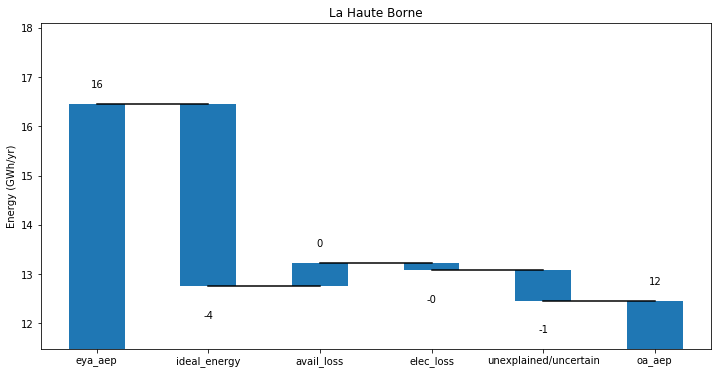

In [31]:
gap_anal.run()

In this example, they EYA estimate of AEP was about 5% higher than the OA result. This difference is explained by a large difference in turbine ideal energy (overestimated in EYA), and smaller differences in availability and electrical losses (underestimated in EYA). A total of 10 GWh/yr, or about 2%, is unexplained or uncertain using this approach.